# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config (display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

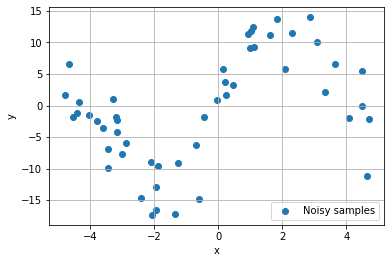

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

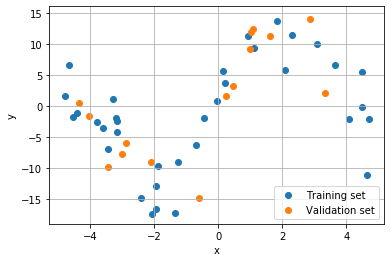

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [8]:
PolynomialFeatures(degree=4).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.,   1.],
       [  1.,   3.,   9.,  27.,  81.],
       [  1.,   4.,  16.,  64., 256.]])

In [9]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression(fit_intercept=False)
    
    # lasso regression
    elif penalty == 'L1':
        regressor = Lasso(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    # ridge regression
    elif penalty == 'L2':
        regressor = Ridge(fit_intercept=False, alpha=alpha, random_state=SEED, max_iter=50000)        
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg', LinearRegression(fit_intercept=False))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Lasso(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures()), ('sca', StandardScaler()),
                ('reg',
                 Ridge(alpha=0.1, fit_intercept=False, max_iter=50000,
                       random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

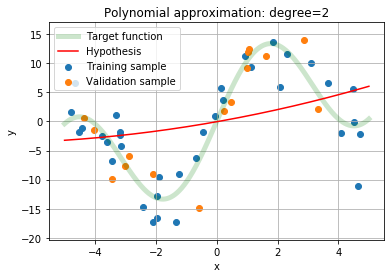

In [10]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

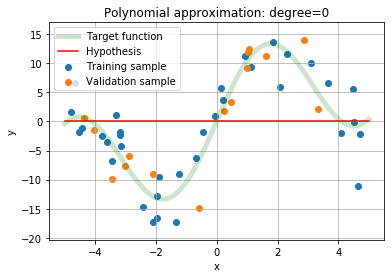

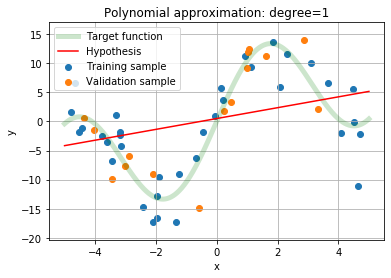

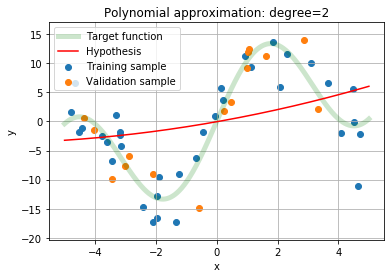

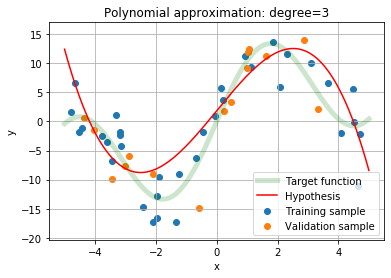

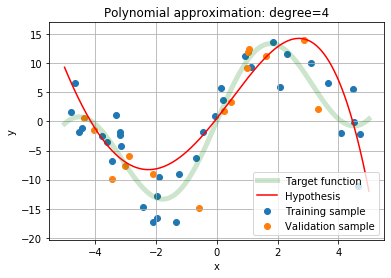

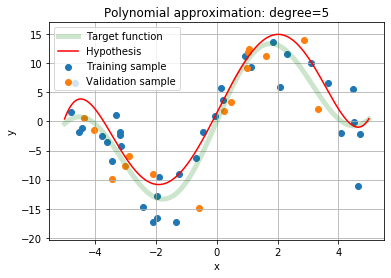

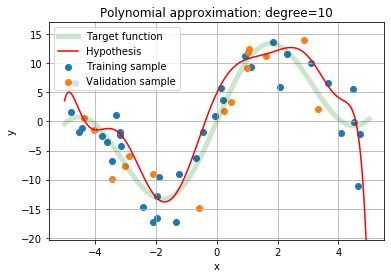

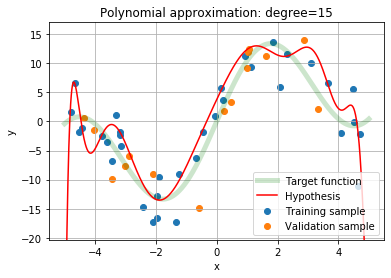

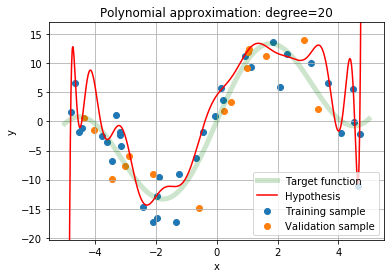

In [11]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

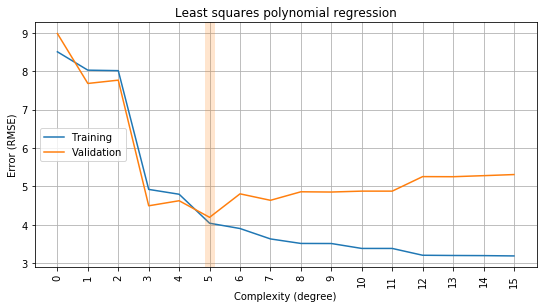

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [13]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

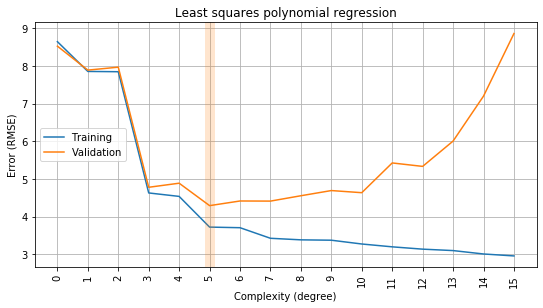

In [14]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [15]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([0.        , 2.81292778]),
 array([0.        , 2.80049884, 0.45166501]),
 array([  0.        ,  30.87315584,   1.48752361, -54.60227825,
         -1.63699842,  26.62792933]),
 array([   0.        ,   33.63850705,  -41.86346242,  -70.48743112,
         278.98853452,   27.48125634, -656.36383501,   59.32988346,
         651.64795186,  -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

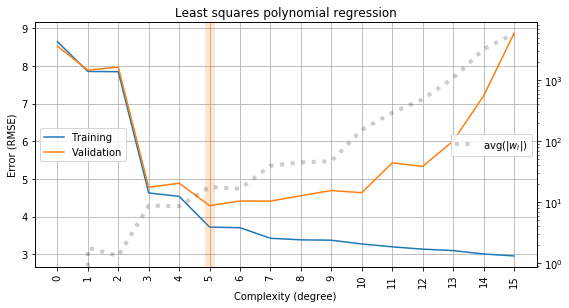

In [16]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

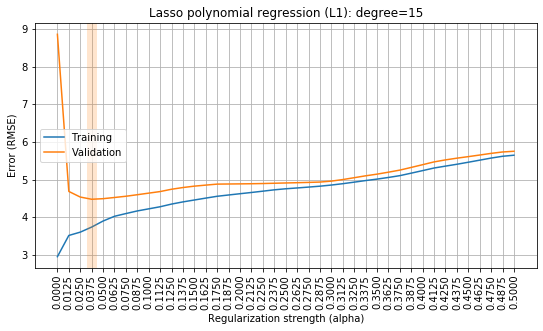

In [17]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

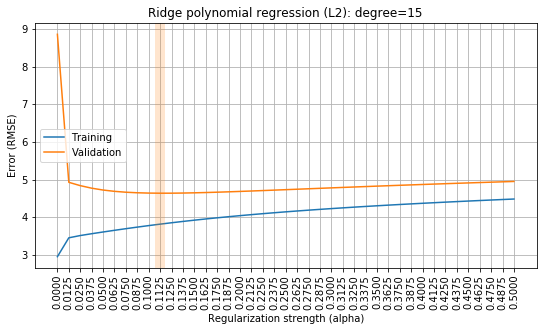

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Magnitude (4 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [19]:
for alpha in ALPHAS:    
    importance_L1 = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_
    minimum=importance_L1.min()
    maximum=importance_L1.max()
    print('alpha=%.5f: Min weight=%.5f, Max weight=%.5f' % (alpha,minimum,maximum))      

alpha=0.00000: Min weight=-7770.35734, Max weight=10759.22010
alpha=0.01250: Min weight=-47.58344, Max weight=29.88455
alpha=0.02500: Min weight=-41.33520, Max weight=27.92025
alpha=0.03750: Min weight=-35.34802, Max weight=25.91508
alpha=0.05000: Min weight=-29.88276, Max weight=24.10613
alpha=0.06250: Min weight=-25.75814, Max weight=22.73877
alpha=0.07500: Min weight=-24.47739, Max weight=22.04269
alpha=0.08750: Min weight=-23.14437, Max weight=21.31857
alpha=0.10000: Min weight=-21.62740, Max weight=20.57765
alpha=0.11250: Min weight=-20.16303, Max weight=19.85881
alpha=0.12500: Min weight=-19.14219, Max weight=19.25410
alpha=0.13750: Min weight=-18.10019, Max weight=18.65707
alpha=0.15000: Min weight=-17.12629, Max weight=18.09985
alpha=0.16250: Min weight=-16.32151, Max weight=17.59813
alpha=0.17500: Min weight=-15.52427, Max weight=17.10139
alpha=0.18750: Min weight=-15.16142, Max weight=16.81166
alpha=0.20000: Min weight=-14.94281, Max weight=16.59140
alpha=0.21250: Min weight=

#### L2

In [20]:
for alpha in ALPHAS:    
    importance_L2 = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_
    minimum=importance_L2.min()
    maximum=importance_L2.max()
    print('alpha=%.5f: Min weight=%.5f, Max weight=%.5f ' % (alpha,minimum,maximum))    

alpha=0.00000: Min weight=-7770.35734, Max weight=10759.22010 
alpha=0.01250: Min weight=-45.75366, Max weight=29.42085 
alpha=0.02500: Min weight=-39.59759, Max weight=27.85460 
alpha=0.03750: Min weight=-35.87017, Max weight=26.74180 
alpha=0.05000: Min weight=-33.08515, Max weight=25.84079 
alpha=0.06250: Min weight=-30.83986, Max weight=25.07723 
alpha=0.07500: Min weight=-28.95969, Max weight=24.41426 
alpha=0.08750: Min weight=-27.34829, Max weight=23.82921 
alpha=0.10000: Min weight=-25.94468, Max weight=23.30659 
alpha=0.11250: Min weight=-24.70695, Max weight=22.83513 
alpha=0.12500: Min weight=-23.60469, Max weight=22.40631 
alpha=0.13750: Min weight=-22.61500, Max weight=22.01352 
alpha=0.15000: Min weight=-21.72015, Max weight=21.65154 
alpha=0.16250: Min weight=-20.90612, Max weight=21.31613 
alpha=0.17500: Min weight=-20.16164, Max weight=21.00387 
alpha=0.18750: Min weight=-19.47751, Max weight=20.71192 
alpha=0.20000: Min weight=-18.84615, Max weight=20.43789 
alpha=0.2

#### Summary

Как видно с увелечинеим alpha, максимальный и минимальный коэффициент стремиться к нулю.

### Excercise 2 - Sparsity (4 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

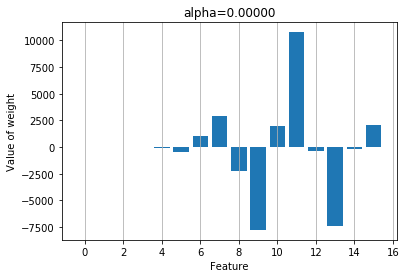

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 33.54429
Feature: 2, Score: -7.39916
Feature: 3, Score: -37.43401
Feature: 4, Score: -127.81295
Feature: 5, Score: -473.61969
Feature: 6, Score: 994.29067
Feature: 7, Score: 2910.25278
Feature: 8, Score: -2261.13628
Feature: 9, Score: -7770.35734
Feature: 10, Score: 1930.66378
Feature: 11, Score: 10759.22010
Feature: 12, Score: -350.33874
Feature: 13, Score: -7447.97064
Feature: 14, Score: -179.92103
Feature: 15, Score: 2028.80397


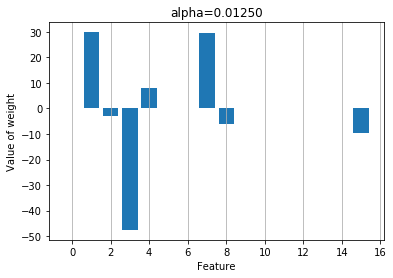

Number of features=7
Feature: 0, Score: 0.00000
Feature: 1, Score: 29.88455
Feature: 2, Score: -2.91716
Feature: 3, Score: -47.58344
Feature: 4, Score: 8.17658
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 29.59373
Feature: 8, Score: -5.98220
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -9.50756


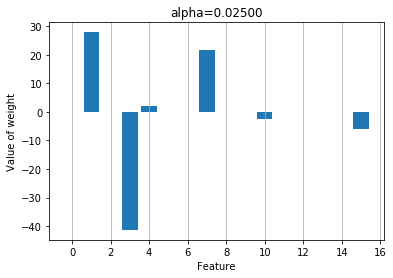

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 27.92025
Feature: 2, Score: -0.00000
Feature: 3, Score: -41.33520
Feature: 4, Score: 2.03382
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 21.83331
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -2.51879
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -6.00484


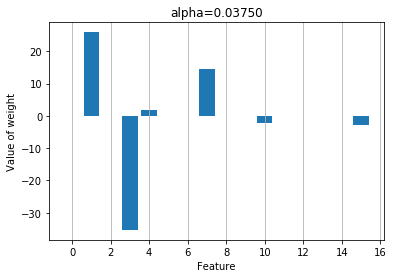

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 25.91508
Feature: 2, Score: 0.00000
Feature: 3, Score: -35.34802
Feature: 4, Score: 1.96698
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 14.62256
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -2.36284
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -2.80186


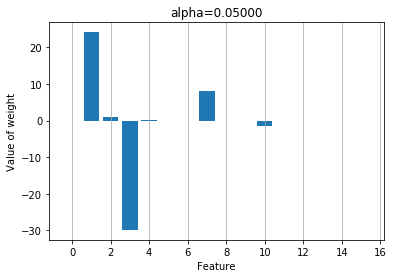

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 24.10613
Feature: 2, Score: 1.04042
Feature: 3, Score: -29.88276
Feature: 4, Score: 0.22845
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 8.16117
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -1.52176
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


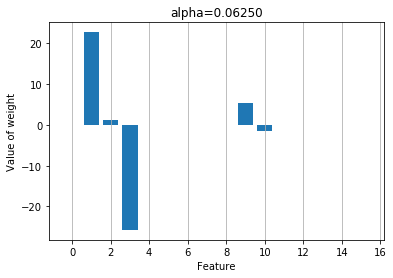

Number of features=5
Feature: 0, Score: 0.00000
Feature: 1, Score: 22.73877
Feature: 2, Score: 1.19755
Feature: 3, Score: -25.75814
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 5.33793
Feature: 10, Score: -1.41475
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


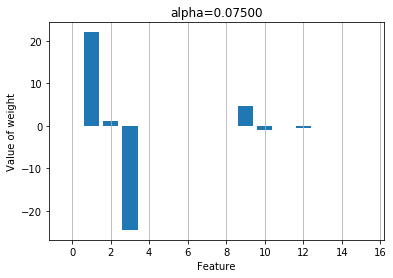

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 22.04269
Feature: 2, Score: 1.12620
Feature: 3, Score: -24.47739
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 4.66683
Feature: 10, Score: -0.88209
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.47071
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: 0.00000


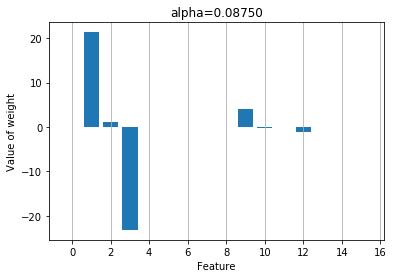

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 21.31857
Feature: 2, Score: 1.05427
Feature: 3, Score: -23.14437
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 3.96710
Feature: 10, Score: -0.25027
Feature: 11, Score: 0.00000
Feature: 12, Score: -1.04242
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: 0.00000


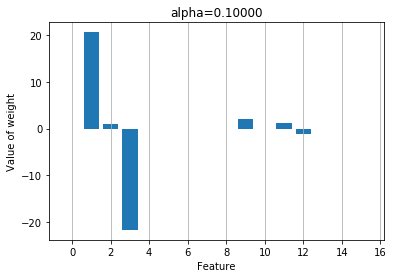

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 20.57765
Feature: 2, Score: 1.01590
Feature: 3, Score: -21.62740
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 1.99322
Feature: 10, Score: -0.00000
Feature: 11, Score: 1.12304
Feature: 12, Score: -1.25384
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: 0.00000


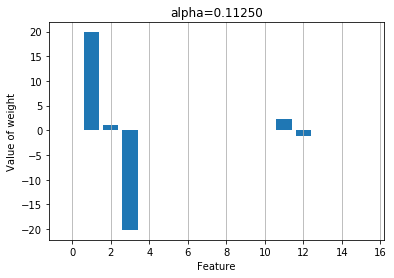

Number of features=5
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.85881
Feature: 2, Score: 0.99285
Feature: 3, Score: -20.16303
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 2.30536
Feature: 12, Score: -1.22516
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: 0.00000


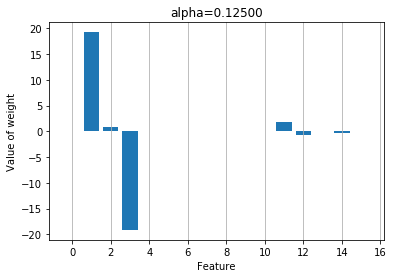

Number of features=6
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.25410
Feature: 2, Score: 0.93302
Feature: 3, Score: -19.14219
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 1.81191
Feature: 12, Score: -0.77318
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.40225
Feature: 15, Score: 0.00000


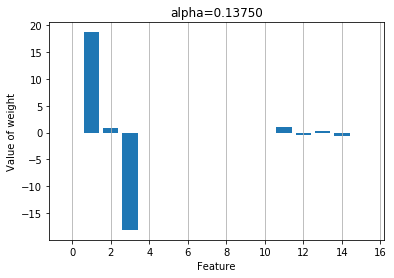

Number of features=7
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.65707
Feature: 2, Score: 0.89240
Feature: 3, Score: -18.10019
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 1.00073
Feature: 12, Score: -0.54334
Feature: 13, Score: 0.29527
Feature: 14, Score: -0.59784
Feature: 15, Score: 0.00000


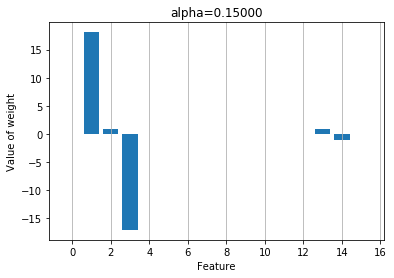

Number of features=5
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.09985
Feature: 2, Score: 0.82463
Feature: 3, Score: -17.12629
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.81396
Feature: 14, Score: -1.07985
Feature: 15, Score: 0.00000


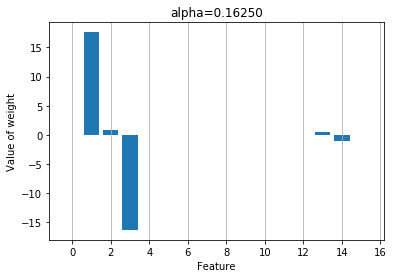

Number of features=5
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.59813
Feature: 2, Score: 0.78877
Feature: 3, Score: -16.32151
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.45005
Feature: 14, Score: -1.05060
Feature: 15, Score: 0.00000


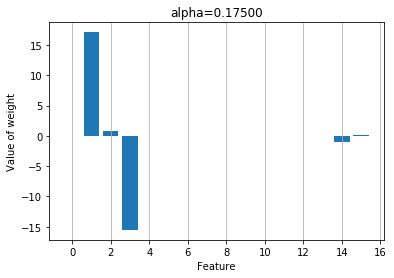

Number of features=5
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.10139
Feature: 2, Score: 0.75198
Feature: 3, Score: -15.52427
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -1.01894
Feature: 15, Score: 0.09137


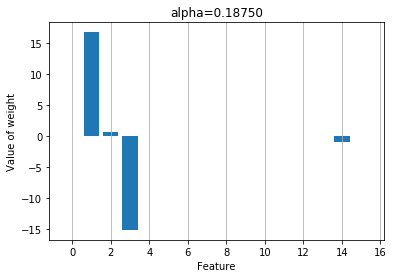

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.81166
Feature: 2, Score: 0.68310
Feature: 3, Score: -15.16142
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.94446
Feature: 15, Score: 0.00000


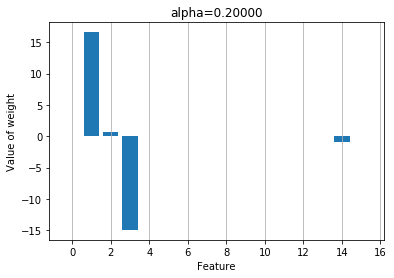

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.59140
Feature: 2, Score: 0.59969
Feature: 3, Score: -14.94281
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.85016
Feature: 15, Score: 0.00000


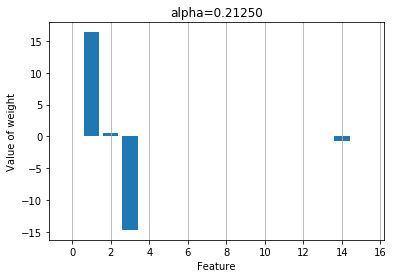

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.37257
Feature: 2, Score: 0.51767
Feature: 3, Score: -14.72555
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.75708
Feature: 15, Score: 0.00000


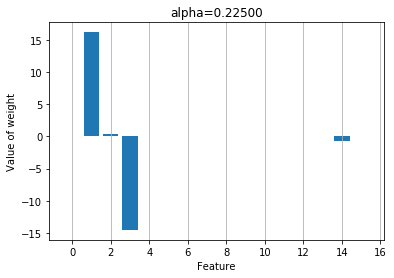

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.15405
Feature: 2, Score: 0.43569
Feature: 3, Score: -14.50859
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.66405
Feature: 15, Score: 0.00000


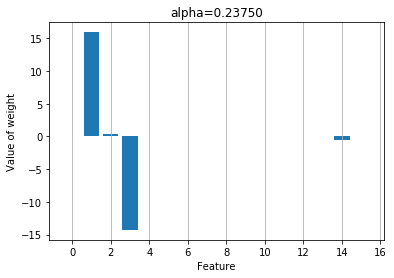

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 15.93526
Feature: 2, Score: 0.35368
Feature: 3, Score: -14.29137
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.57098
Feature: 15, Score: 0.00000


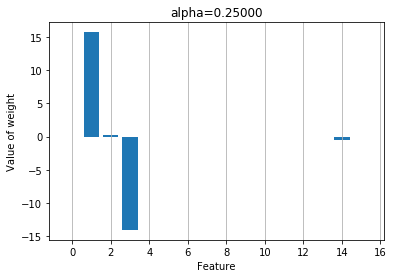

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 15.71660
Feature: 2, Score: 0.27168
Feature: 3, Score: -14.07426
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.47792
Feature: 15, Score: 0.00000


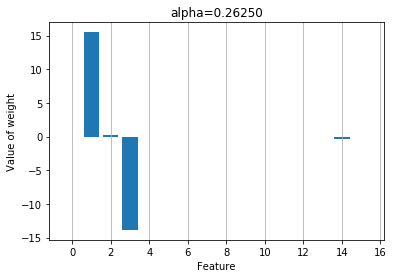

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 15.49791
Feature: 2, Score: 0.18968
Feature: 3, Score: -13.85713
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.38487
Feature: 15, Score: 0.00000


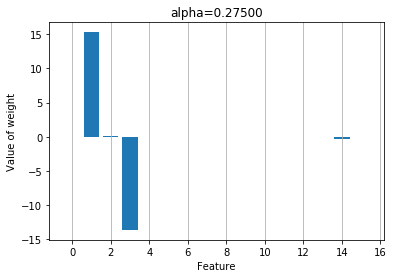

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 15.27899
Feature: 2, Score: 0.10765
Feature: 3, Score: -13.63979
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.29177
Feature: 15, Score: -0.00000


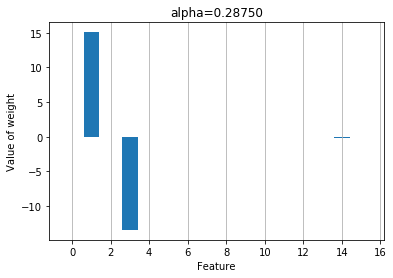

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 15.06052
Feature: 2, Score: 0.02568
Feature: 3, Score: -13.42287
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.19875
Feature: 15, Score: -0.00000


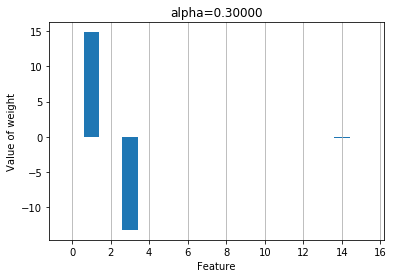

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 14.85476
Feature: 2, Score: 0.00000
Feature: 3, Score: -13.21813
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.15187
Feature: 15, Score: -0.00000


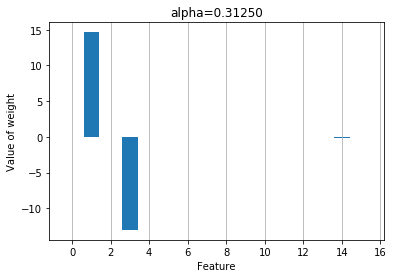

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 14.65490
Feature: 2, Score: 0.00000
Feature: 3, Score: -13.01907
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.12605
Feature: 15, Score: -0.00000


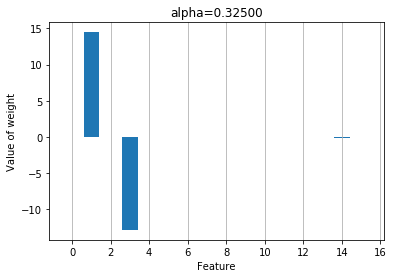

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 14.45463
Feature: 2, Score: 0.00000
Feature: 3, Score: -12.81962
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.10021
Feature: 15, Score: -0.00000


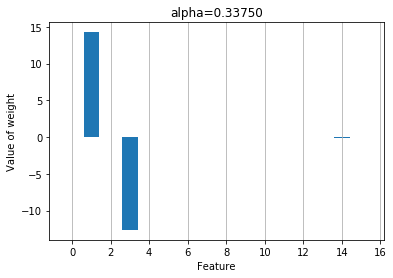

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 14.25474
Feature: 2, Score: 0.00000
Feature: 3, Score: -12.62052
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00000
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.07439
Feature: 15, Score: -0.00000


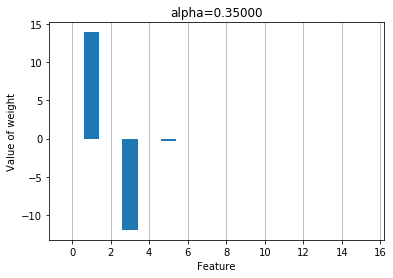

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 13.90519
Feature: 2, Score: 0.00000
Feature: 3, Score: -11.94341
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.34324
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.05270
Feature: 15, Score: -0.00000


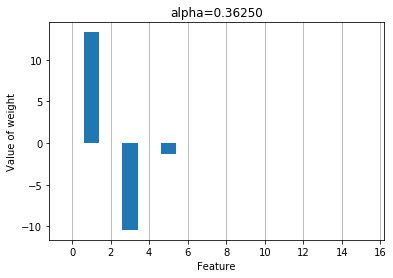

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 13.30226
Feature: 2, Score: 0.00000
Feature: 3, Score: -10.41760
Feature: 4, Score: 0.00000
Feature: 5, Score: -1.31031
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.03975
Feature: 15, Score: -0.00000


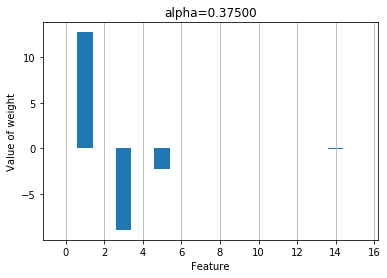

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 12.70048
Feature: 2, Score: 0.00000
Feature: 3, Score: -8.89522
Feature: 4, Score: 0.00000
Feature: 5, Score: -2.27500
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.02679
Feature: 15, Score: -0.00000


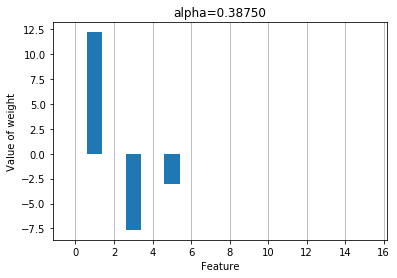

Number of features=4
Feature: 0, Score: 0.00000
Feature: 1, Score: 12.18993
Feature: 2, Score: 0.00000
Feature: 3, Score: -7.64714
Feature: 4, Score: 0.00000
Feature: 5, Score: -3.04860
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.01206
Feature: 15, Score: -0.00000


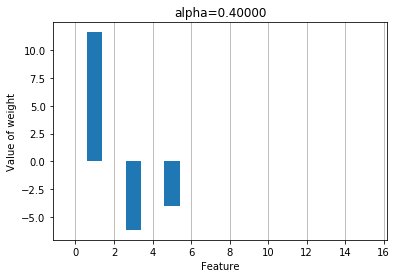

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 11.59702
Feature: 2, Score: 0.00000
Feature: 3, Score: -6.14510
Feature: 4, Score: 0.00000
Feature: 5, Score: -4.00098
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


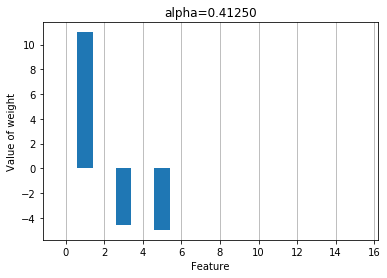

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 10.99822
Feature: 2, Score: 0.00000
Feature: 3, Score: -4.61600
Feature: 4, Score: 0.00000
Feature: 5, Score: -4.97543
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


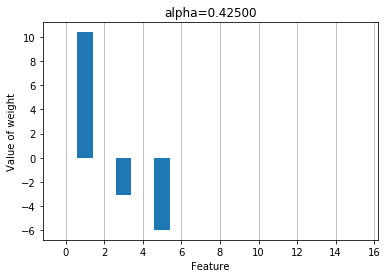

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 10.38981
Feature: 2, Score: 0.00000
Feature: 3, Score: -3.05868
Feature: 4, Score: 0.00000
Feature: 5, Score: -5.96932
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


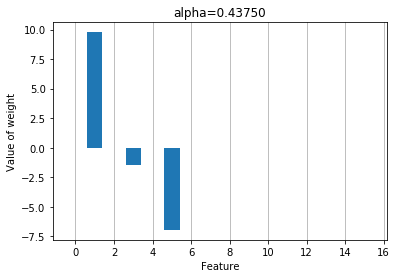

Number of features=3
Feature: 0, Score: 0.00000
Feature: 1, Score: 9.77929
Feature: 2, Score: 0.00000
Feature: 3, Score: -1.49518
Feature: 4, Score: 0.00000
Feature: 5, Score: -6.96748
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


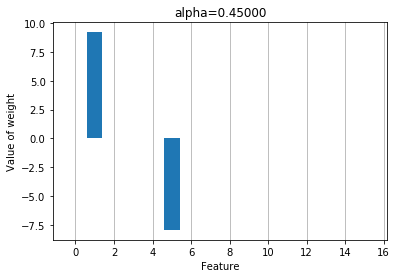

Number of features=2
Feature: 0, Score: 0.00000
Feature: 1, Score: 9.19150
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -7.91807
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


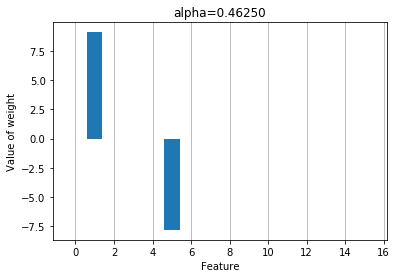

Number of features=2
Feature: 0, Score: 0.00000
Feature: 1, Score: 9.10147
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -7.82793
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


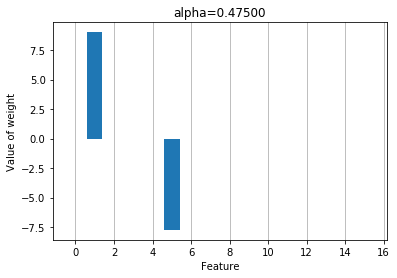

Number of features=2
Feature: 0, Score: 0.00000
Feature: 1, Score: 9.01119
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -7.73758
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


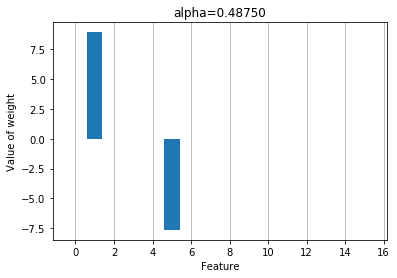

Number of features=2
Feature: 0, Score: 0.00000
Feature: 1, Score: 8.91986
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -7.64632
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


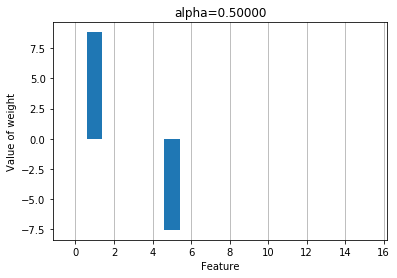

Number of features=2
Feature: 0, Score: 0.00000
Feature: 1, Score: 8.82911
Feature: 2, Score: 0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -7.55555
Feature: 6, Score: -0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00000
Feature: 10, Score: -0.00000
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000


In [22]:
## your code
for alpha in ALPHAS:    
    importance = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)['reg'].coef_
    val=np.count_nonzero(importance)
    plt.bar([i for i in range(len(importance))], importance)
    plt.title("alpha=%.5f" %(alpha))
    plt.xlabel("Feature")
    plt.ylabel("Value of weight")
    plt.grid(axis="x")
    plt.show()
    print("Number of features=%d" %val)
    # summarize feature importance
    for i,v in enumerate(importance):
  
      print('Feature: %0d, Score: %.5f' % (i,v))

#### L2

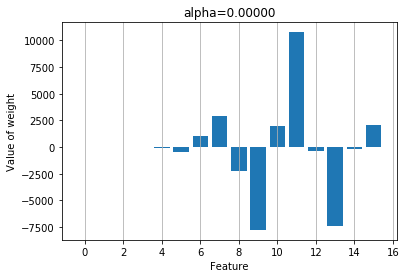

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 33.54429
Feature: 2, Score: -7.39916
Feature: 3, Score: -37.43401
Feature: 4, Score: -127.81295
Feature: 5, Score: -473.61969
Feature: 6, Score: 994.29067
Feature: 7, Score: 2910.25278
Feature: 8, Score: -2261.13628
Feature: 9, Score: -7770.35734
Feature: 10, Score: 1930.66378
Feature: 11, Score: 10759.22010
Feature: 12, Score: -350.33874
Feature: 13, Score: -7447.97064
Feature: 14, Score: -179.92103
Feature: 15, Score: 2028.80397


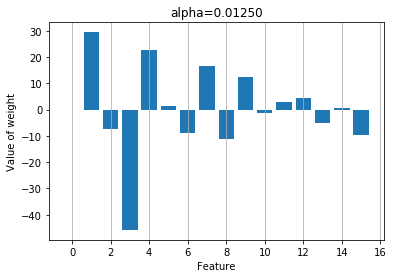

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 29.42085
Feature: 2, Score: -7.45042
Feature: 3, Score: -45.75366
Feature: 4, Score: 22.65303
Feature: 5, Score: 1.48626
Feature: 6, Score: -8.82022
Feature: 7, Score: 16.70224
Feature: 8, Score: -11.06298
Feature: 9, Score: 12.45804
Feature: 10, Score: -1.43145
Feature: 11, Score: 2.89619
Feature: 12, Score: 4.53806
Feature: 13, Score: -5.27373
Feature: 14, Score: 0.74125
Feature: 15, Score: -9.52410


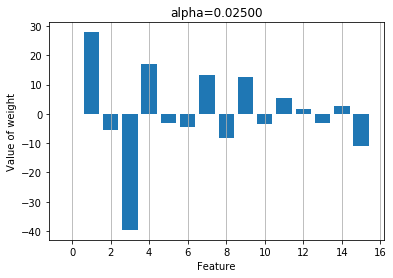

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 27.85460
Feature: 2, Score: -5.63273
Feature: 3, Score: -39.59759
Feature: 4, Score: 16.85660
Feature: 5, Score: -2.94820
Feature: 6, Score: -4.33575
Feature: 7, Score: 13.10054
Feature: 8, Score: -8.38775
Feature: 9, Score: 12.71178
Feature: 10, Score: -3.46894
Feature: 11, Score: 5.49702
Feature: 12, Score: 1.52967
Feature: 13, Score: -3.22293
Feature: 14, Score: 2.69475
Feature: 15, Score: -11.02273


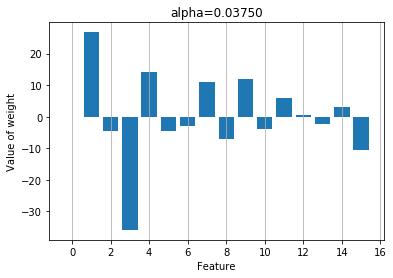

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 26.74180
Feature: 2, Score: -4.54238
Feature: 3, Score: -35.87017
Feature: 4, Score: 14.01672
Feature: 5, Score: -4.63253
Feature: 6, Score: -2.87460
Feature: 7, Score: 10.96440
Feature: 8, Score: -7.09475
Feature: 9, Score: 11.97706
Feature: 10, Score: -3.78072
Feature: 11, Score: 6.03611
Feature: 12, Score: 0.59986
Feature: 13, Score: -2.25375
Feature: 14, Score: 3.00555
Feature: 15, Score: -10.61611


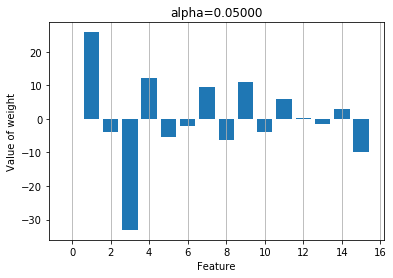

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 25.84079
Feature: 2, Score: -3.75689
Feature: 3, Score: -33.08515
Feature: 4, Score: 12.17107
Feature: 5, Score: -5.50443
Feature: 6, Score: -2.18498
Feature: 7, Score: 9.39004
Feature: 8, Score: -6.26671
Feature: 9, Score: 11.09779
Feature: 10, Score: -3.75088
Feature: 11, Score: 6.05381
Feature: 12, Score: 0.18426
Feature: 13, Score: -1.63242
Feature: 14, Score: 2.99528
Feature: 15, Score: -9.83487


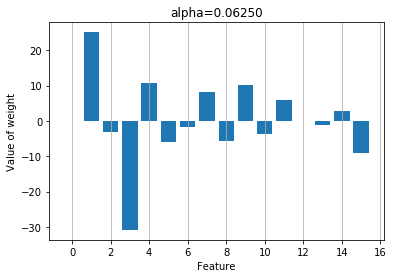

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 25.07723
Feature: 2, Score: -3.14934
Feature: 3, Score: -30.83986
Feature: 4, Score: 10.82643
Feature: 5, Score: -6.02623
Feature: 6, Score: -1.79733
Feature: 7, Score: 8.13697
Feature: 8, Score: -5.66880
Feature: 9, Score: 10.24388
Feature: 10, Score: -3.62671
Feature: 11, Score: 5.89505
Feature: 12, Score: -0.03555
Feature: 13, Score: -1.18155
Feature: 14, Score: 2.89401
Feature: 15, Score: -8.99937


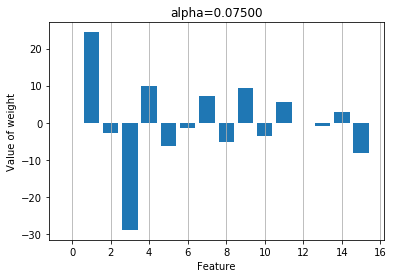

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 24.41426
Feature: 2, Score: -2.66088
Feature: 3, Score: -28.95969
Feature: 4, Score: 9.78465
Feature: 5, Score: -6.36467
Feature: 6, Score: -1.55449
Feature: 7, Score: 7.10122
Feature: 8, Score: -5.20686
Feature: 9, Score: 9.45710
Feature: 10, Score: -3.47744
Feature: 11, Score: 5.67299
Feature: 12, Score: -0.16404
Feature: 13, Score: -0.83305
Feature: 14, Score: 2.76534
Feature: 15, Score: -8.20056


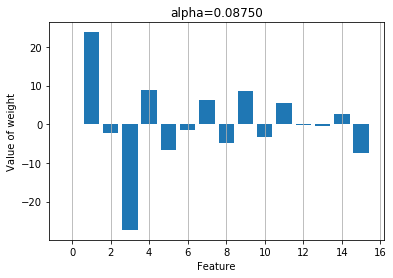

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 23.82921
Feature: 2, Score: -2.25823
Feature: 3, Score: -27.34829
Feature: 4, Score: 8.94579
Feature: 5, Score: -6.59477
Feature: 6, Score: -1.39004
Feature: 7, Score: 6.22534
Feature: 8, Score: -4.83405
Feature: 9, Score: 8.74442
Feature: 10, Score: -3.32649
Feature: 11, Score: 5.43201
Feature: 12, Score: -0.24452
Feature: 13, Score: -0.55349
Feature: 14, Score: 2.63098
Feature: 15, Score: -7.46481


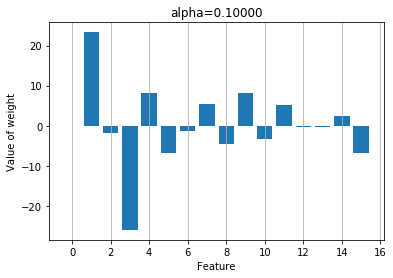

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 23.30659
Feature: 2, Score: -1.92033
Feature: 3, Score: -25.94468
Feature: 4, Score: 8.25211
Feature: 5, Score: -6.75544
Feature: 6, Score: -1.27165
Feature: 7, Score: 5.47288
Feature: 8, Score: -4.52385
Feature: 9, Score: 8.10209
Feature: 10, Score: -3.18233
Feature: 11, Score: 5.19111
Feature: 12, Score: -0.29770
Feature: 13, Score: -0.32377
Feature: 14, Score: 2.49911
Feature: 15, Score: -6.79682


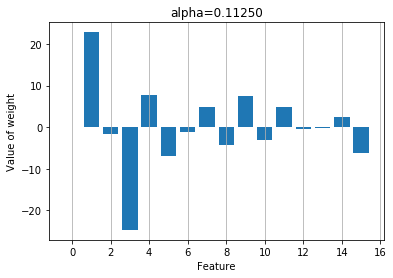

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 22.83513
Feature: 2, Score: -1.63287
Feature: 3, Score: -24.70695
Feature: 4, Score: 7.66710
Feature: 5, Score: -6.86891
Feature: 6, Score: -1.18202
Feature: 7, Score: 4.81875
Feature: 8, Score: -4.25983
Feature: 9, Score: 7.52328
Feature: 10, Score: -3.04780
Feature: 11, Score: 4.95863
Feature: 12, Score: -0.33447
Feature: 13, Score: -0.13179
Feature: 14, Score: 2.37286
Feature: 15, Score: -6.19356


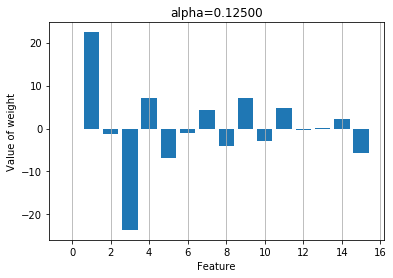

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 22.40631
Feature: 2, Score: -1.38565
Feature: 3, Score: -23.60469
Feature: 4, Score: 7.16619
Feature: 5, Score: -6.94886
Feature: 6, Score: -1.11118
Feature: 7, Score: 4.24474
Feature: 8, Score: -4.03116
Feature: 9, Score: 7.00072
Feature: 10, Score: -2.92350
Feature: 11, Score: 4.73803
Feature: 12, Score: -0.36095
Feature: 13, Score: 0.03063
Feature: 14, Score: 2.25324
Feature: 15, Score: -5.64943


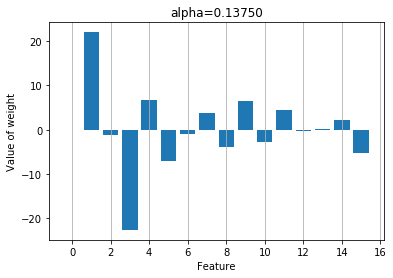

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 22.01352
Feature: 2, Score: -1.17111
Feature: 3, Score: -22.61500
Feature: 4, Score: 6.73202
Feature: 5, Score: -7.00419
Feature: 6, Score: -1.05313
Feature: 7, Score: 3.73709
Feature: 8, Score: -3.83035
Feature: 9, Score: 6.52760
Feature: 10, Score: -2.80907
Feature: 11, Score: 4.53046
Feature: 12, Score: -0.38079
Feature: 13, Score: 0.16935
Feature: 14, Score: 2.14041
Feature: 15, Score: -5.15830


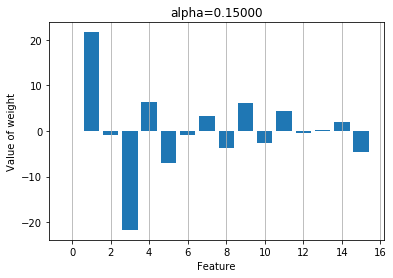

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 21.65154
Feature: 2, Score: -0.98350
Feature: 3, Score: -21.72015
Feature: 4, Score: 6.35190
Feature: 5, Score: -7.04095
Feature: 6, Score: -1.00405
Feature: 7, Score: 3.28517
Feature: 8, Score: -3.65199
Feature: 9, Score: 6.09787
Feature: 10, Score: -2.70382
Feature: 11, Score: 4.33593
Feature: 12, Score: -0.39621
Feature: 13, Score: 0.28867
Feature: 14, Score: 2.03413
Feature: 15, Score: -4.71424


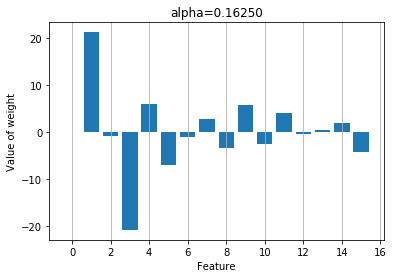

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 21.31613
Feature: 2, Score: -0.81837
Feature: 3, Score: -20.90612
Feature: 4, Score: 6.01625
Feature: 5, Score: -7.06339
Feature: 6, Score: -0.96146
Feature: 7, Score: 2.88055
Feature: 8, Score: -3.49209
Feature: 9, Score: 5.70626
Feature: 10, Score: -2.60694
Feature: 11, Score: 4.15390
Feature: 12, Score: -0.40866
Feature: 13, Score: 0.39192
Feature: 14, Score: 1.93401
Feature: 15, Score: -4.31190


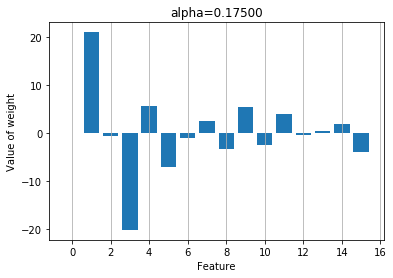

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 21.00387
Feature: 2, Score: -0.67217
Feature: 3, Score: -20.16164
Feature: 4, Score: 5.71771
Feature: 5, Score: -7.07461
Feature: 6, Score: -0.92369
Feature: 7, Score: 2.51649
Feature: 8, Score: -3.34760
Feature: 9, Score: 5.34823
Feature: 10, Score: -2.51761
Feature: 11, Score: 3.98360
Feature: 12, Score: -0.41904
Feature: 13, Score: 0.48165
Feature: 14, Score: 1.83962
Feature: 15, Score: -3.94649


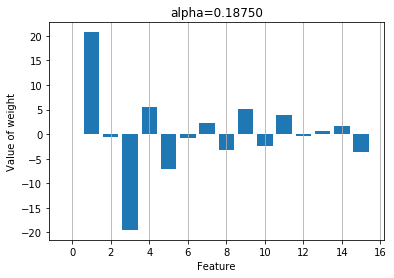

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 20.71192
Feature: 2, Score: -0.54208
Feature: 3, Score: -19.47751
Feature: 4, Score: 5.45047
Feature: 5, Score: -7.07690
Feature: 6, Score: -0.88960
Feature: 7, Score: 2.18745
Feature: 8, Score: -3.21615
Feature: 9, Score: 5.01986
Feature: 10, Score: -2.43508
Feature: 11, Score: 3.82417
Feature: 12, Score: -0.42800
Feature: 13, Score: 0.55991
Feature: 14, Score: 1.75050
Feature: 15, Score: -3.61384


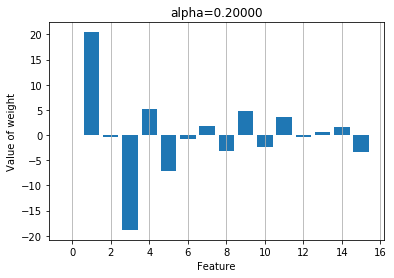

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 20.43789
Feature: 2, Score: -0.42580
Feature: 3, Score: -18.84615
Feature: 4, Score: 5.20990
Feature: 5, Score: -7.07202
Feature: 6, Score: -0.85837
Feature: 7, Score: 1.88889
Feature: 8, Score: -3.09585
Feature: 9, Score: 4.71780
Feature: 10, Score: -2.35866
Feature: 11, Score: 3.67476
Feature: 12, Score: -0.43593
Feature: 13, Score: 0.62836
Feature: 14, Score: 1.66625
Feature: 15, Score: -3.31029


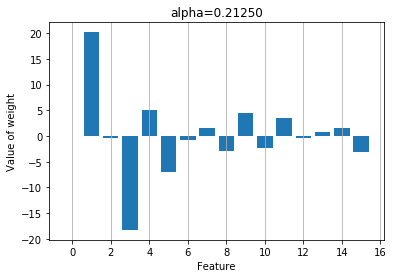

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 20.17981
Feature: 2, Score: -0.32142
Feature: 3, Score: -18.26122
Feature: 4, Score: 4.99226
Feature: 5, Score: -7.06130
Feature: 6, Score: -0.82942
Feature: 7, Score: 1.61703
Feature: 8, Score: -2.98520
Feature: 9, Score: 4.43915
Feature: 10, Score: -2.28775
Feature: 11, Score: 3.53453
Feature: 12, Score: -0.44314
Feature: 13, Score: 0.68834
Feature: 14, Score: 1.58649
Feature: 15, Score: -3.03268


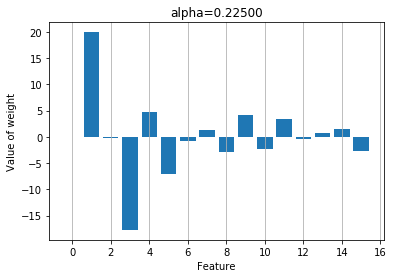

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.93598
Feature: 2, Score: -0.22739
Feature: 3, Score: -17.71741
Feature: 4, Score: 4.79448
Feature: 5, Score: -7.04581
Feature: 6, Score: -0.80234
Feature: 7, Score: 1.36868
Feature: 8, Score: -2.88296
Feature: 9, Score: 4.18140
Feature: 10, Score: -2.22179
Feature: 11, Score: 3.40273
Feature: 12, Score: -0.44980
Feature: 13, Score: 0.74098
Feature: 14, Score: 1.51085
Feature: 15, Score: -2.77823


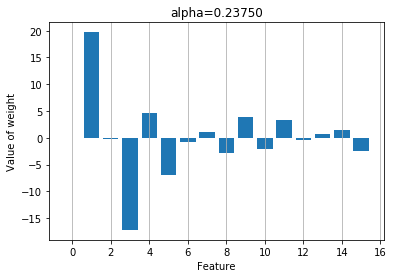

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.70494
Feature: 2, Score: -0.14237
Feature: 3, Score: -17.21018
Feature: 4, Score: 4.61400
Feature: 5, Score: -7.02640
Feature: 6, Score: -0.77680
Feature: 7, Score: 1.14114
Feature: 8, Score: -2.78812
Feature: 9, Score: 3.94239
Feature: 10, Score: -2.16030
Feature: 11, Score: 3.27864
Feature: 12, Score: -0.45607
Feature: 13, Score: 0.78721
Feature: 14, Score: 1.43904
Feature: 15, Score: -2.54454


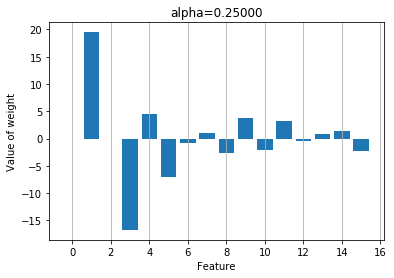

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.48547
Feature: 2, Score: -0.06528
Feature: 3, Score: -16.73568
Feature: 4, Score: 4.44870
Feature: 5, Score: -7.00373
Feature: 6, Score: -0.75258
Feature: 7, Score: 0.93210
Feature: 8, Score: -2.69983
Feature: 9, Score: 3.72022
Feature: 10, Score: -2.10286
Feature: 11, Score: 3.16161
Feature: 12, Score: -0.46204
Feature: 13, Score: 0.82780
Feature: 14, Score: 1.37075
Feature: 15, Score: -2.32949


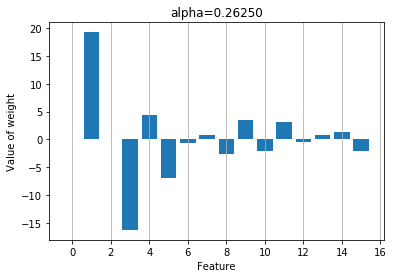

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.27647
Feature: 2, Score: 0.00483
Feature: 3, Score: -16.29059
Feature: 4, Score: 4.29679
Feature: 5, Score: -6.97836
Feature: 6, Score: -0.72949
Feature: 7, Score: 0.73960
Feature: 8, Score: -2.61737
Feature: 9, Score: 3.51324
Feature: 10, Score: -2.04909
Feature: 11, Score: 3.05108
Feature: 12, Score: -0.46778
Feature: 13, Score: 0.86343
Feature: 14, Score: 1.30573
Feature: 15, Score: -2.13125


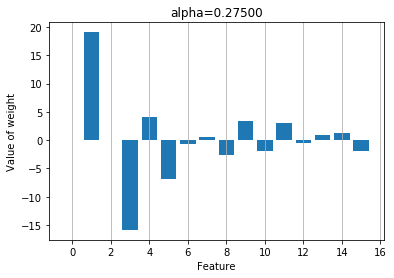

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 19.07701
Feature: 2, Score: 0.06877
Feature: 3, Score: -15.87203
Feature: 4, Score: 4.15674
Feature: 5, Score: -6.95074
Feature: 6, Score: -0.70739
Feature: 7, Score: 0.56191
Feature: 8, Score: -2.54013
Feature: 9, Score: 3.32002
Feature: 10, Score: -1.99864
Feature: 11, Score: 2.94650
Feature: 12, Score: -0.47333
Feature: 13, Score: 0.89467
Feature: 14, Score: 1.24374
Feature: 15, Score: -1.94818


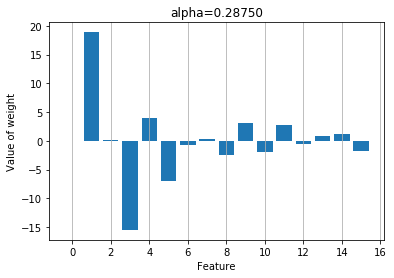

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.88628
Feature: 2, Score: 0.12722
Feature: 3, Score: -15.47750
Feature: 4, Score: 4.02725
Feature: 5, Score: -6.92126
Feature: 6, Score: -0.68617
Feature: 7, Score: 0.39757
Feature: 8, Score: -2.46760
Feature: 9, Score: 3.13928
Feature: 10, Score: -1.95124
Feature: 11, Score: 2.84740
Feature: 12, Score: -0.47873
Feature: 13, Score: 0.92201
Feature: 14, Score: 1.18459
Feature: 15, Score: -1.77885


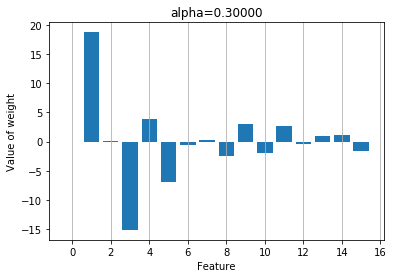

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.70354
Feature: 2, Score: 0.18078
Feature: 3, Score: -15.10481
Feature: 4, Score: 3.90721
Feature: 5, Score: -6.89021
Feature: 6, Score: -0.66575
Feature: 7, Score: 0.24526
Feature: 8, Score: -2.39931
Feature: 9, Score: 2.96990
Feature: 10, Score: -1.90661
Feature: 11, Score: 2.75336
Feature: 12, Score: -0.48400
Feature: 13, Score: 0.94587
Feature: 14, Score: 1.12807
Feature: 15, Score: -1.62200


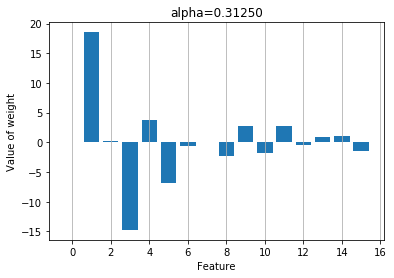

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.52816
Feature: 2, Score: 0.22996
Feature: 3, Score: -14.75205
Feature: 4, Score: 3.79564
Feature: 5, Score: -6.85786
Feature: 6, Score: -0.64606
Feature: 7, Score: 0.10387
Feature: 8, Score: -2.33488
Feature: 9, Score: 2.81089
Feature: 10, Score: -1.86451
Feature: 11, Score: 2.66399
Feature: 12, Score: -0.48915
Feature: 13, Score: 0.96663
Feature: 14, Score: 1.07401
Feature: 15, Score: -1.47651


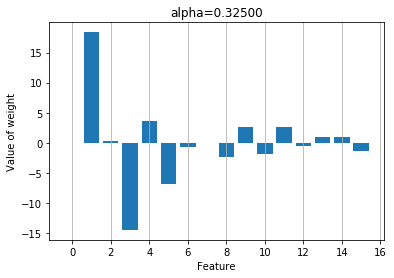

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.35957
Feature: 2, Score: 0.27522
Feature: 3, Score: -14.41750
Feature: 4, Score: 3.69169
Feature: 5, Score: -6.82444
Feature: 6, Score: -0.62703
Feature: 7, Score: -0.02761
Feature: 8, Score: -2.27398
Feature: 9, Score: 2.66136
Feature: 10, Score: -1.82475
Feature: 11, Score: 2.57893
Feature: 12, Score: -0.49421
Feature: 13, Score: 0.98460
Feature: 14, Score: 1.02225
Feature: 15, Score: -1.34137


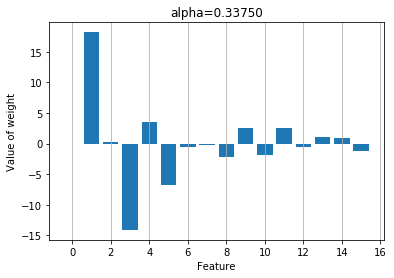

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.19728
Feature: 2, Score: 0.31695
Feature: 3, Score: -14.09968
Feature: 4, Score: 3.59465
Feature: 5, Score: -6.79013
Feature: 6, Score: -0.60863
Feature: 7, Score: -0.15007
Feature: 8, Score: -2.21629
Feature: 9, Score: 2.52053
Feature: 10, Score: -1.78713
Feature: 11, Score: 2.49787
Feature: 12, Score: -0.49916
Feature: 13, Score: 1.00006
Feature: 14, Score: 0.97266
Feature: 15, Score: -1.21571


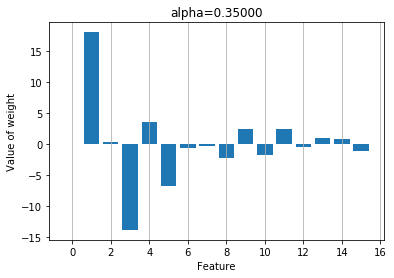

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 18.04082
Feature: 2, Score: 0.35548
Feature: 3, Score: -13.79724
Feature: 4, Score: 3.50385
Feature: 5, Score: -6.75509
Feature: 6, Score: -0.59080
Feature: 7, Score: -0.26429
Feature: 8, Score: -2.16156
Feature: 9, Score: 2.38769
Feature: 10, Score: -1.75148
Feature: 11, Score: 2.42052
Feature: 12, Score: -0.50403
Feature: 13, Score: 1.01326
Feature: 14, Score: 0.92509
Feature: 15, Score: -1.09871


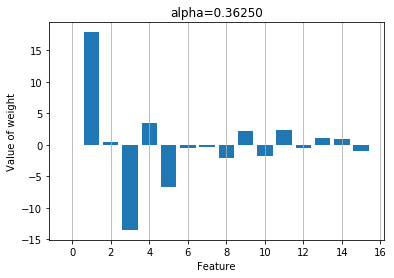

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.88979
Feature: 2, Score: 0.39113
Feature: 3, Score: -13.50899
Feature: 4, Score: 3.41873
Feature: 5, Score: -6.71945
Feature: 6, Score: -0.57352
Feature: 7, Score: -0.37096
Feature: 8, Score: -2.10955
Feature: 9, Score: 2.26221
Feature: 10, Score: -1.71766
Feature: 11, Score: 2.34662
Feature: 12, Score: -0.50881
Feature: 13, Score: 1.02443
Feature: 14, Score: 0.87943
Feature: 15, Score: -0.98968


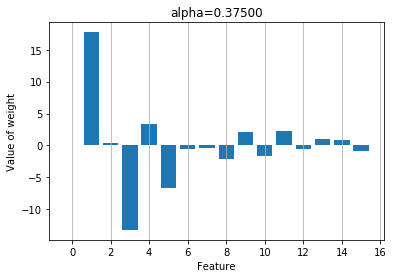

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.74383
Feature: 2, Score: 0.42417
Feature: 3, Score: -13.23385
Feature: 4, Score: 3.33878
Feature: 5, Score: -6.68335
Feature: 6, Score: -0.55675
Feature: 7, Score: -0.47071
Feature: 8, Score: -2.06005
Feature: 9, Score: 2.14353
Feature: 10, Score: -1.68552
Feature: 11, Score: 2.27594
Feature: 12, Score: -0.51350
Feature: 13, Score: 1.03376
Feature: 14, Score: 0.83557
Feature: 15, Score: -0.88797


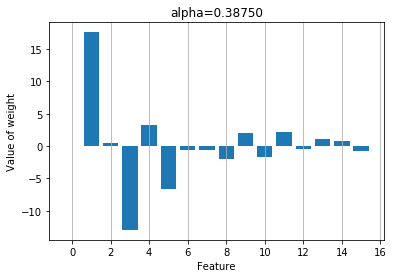

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.60261
Feature: 2, Score: 0.45483
Feature: 3, Score: -12.97088
Feature: 4, Score: 3.26357
Feature: 5, Score: -6.64686
Feature: 6, Score: -0.54047
Feature: 7, Score: -0.56409
Feature: 8, Score: -2.01287
Feature: 9, Score: 2.03113
Feature: 10, Score: -1.65495
Feature: 11, Score: 2.20826
Feature: 12, Score: -0.51811
Feature: 13, Score: 1.04142
Feature: 14, Score: 0.79340
Feature: 15, Score: -0.79299


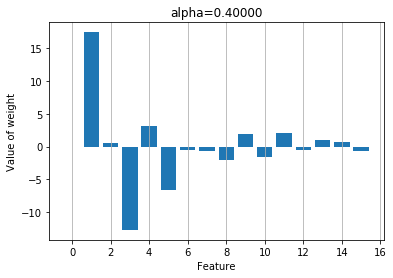

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.46583
Feature: 2, Score: 0.48332
Feature: 3, Score: -12.71919
Feature: 4, Score: 3.19268
Feature: 5, Score: -6.61010
Feature: 6, Score: -0.52466
Feature: 7, Score: -0.65162
Feature: 8, Score: -1.96785
Feature: 9, Score: 1.92456
Feature: 10, Score: -1.62583
Feature: 11, Score: 2.14338
Feature: 12, Score: -0.52263
Feature: 13, Score: 1.04757
Feature: 14, Score: 0.75284
Feature: 15, Score: -0.70424


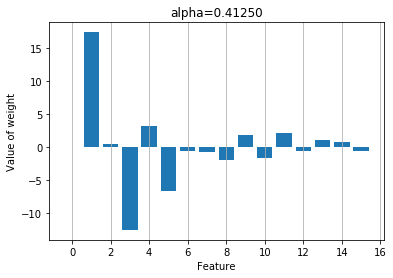

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.33322
Feature: 2, Score: 0.50984
Feature: 3, Score: -12.47802
Feature: 4, Score: 3.12577
Feature: 5, Score: -6.57312
Feature: 6, Score: -0.50929
Feature: 7, Score: -0.73373
Feature: 8, Score: -1.92483
Feature: 9, Score: 1.82340
Feature: 10, Score: -1.59805
Feature: 11, Score: 2.08112
Feature: 12, Score: -0.52707
Feature: 13, Score: 1.05233
Feature: 14, Score: 0.71379
Feature: 15, Score: -0.62124


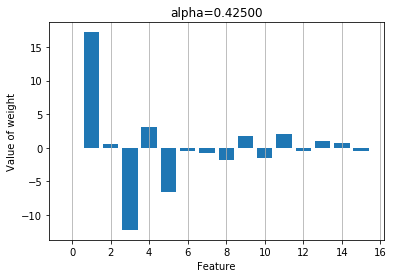

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.20452
Feature: 2, Score: 0.53455
Feature: 3, Score: -12.24664
Feature: 4, Score: 3.06252
Feature: 5, Score: -6.53599
Feature: 6, Score: -0.49434
Feature: 7, Score: -0.81084
Feature: 8, Score: -1.88369
Feature: 9, Score: 1.72726
Feature: 10, Score: -1.57154
Feature: 11, Score: 2.02132
Feature: 12, Score: -0.53143
Feature: 13, Score: 1.05585
Feature: 14, Score: 0.67618
Feature: 15, Score: -0.54356


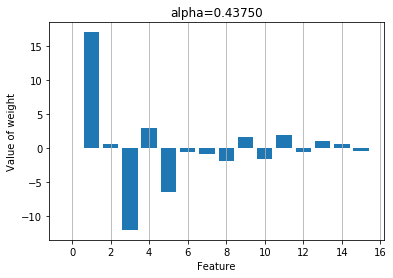

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 17.07953
Feature: 2, Score: 0.55760
Feature: 3, Score: -12.02441
Feature: 4, Score: 3.00265
Feature: 5, Score: -6.49878
Feature: 6, Score: -0.47981
Feature: 7, Score: -0.88332
Feature: 8, Score: -1.84429
Feature: 9, Score: 1.63580
Feature: 10, Score: -1.54620
Feature: 11, Score: 1.96383
Feature: 12, Score: -0.53570
Feature: 13, Score: 1.05823
Feature: 14, Score: 0.63993
Feature: 15, Score: -0.47080


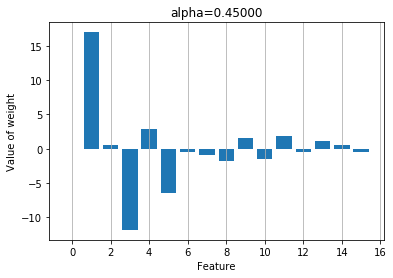

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.95802
Feature: 2, Score: 0.57914
Feature: 3, Score: -11.81076
Feature: 4, Score: 2.94588
Feature: 5, Score: -6.46153
Feature: 6, Score: -0.46567
Feature: 7, Score: -0.95150
Feature: 8, Score: -1.80652
Feature: 9, Score: 1.54871
Feature: 10, Score: -1.52196
Feature: 11, Score: 1.90851
Feature: 12, Score: -0.53989
Feature: 13, Score: 1.05956
Feature: 14, Score: 0.60497
Feature: 15, Score: -0.40263


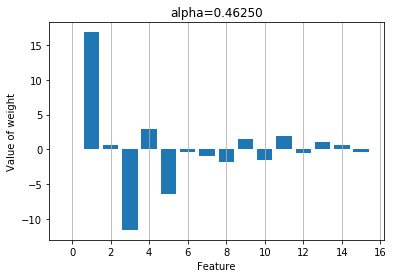

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.83981
Feature: 2, Score: 0.59928
Feature: 3, Score: -11.60513
Feature: 4, Score: 2.89200
Feature: 5, Score: -6.42429
Feature: 6, Score: -0.45190
Feature: 7, Score: -1.01569
Feature: 8, Score: -1.77028
Feature: 9, Score: 1.46569
Feature: 10, Score: -1.49874
Feature: 11, Score: 1.85522
Feature: 12, Score: -0.54399
Feature: 13, Score: 1.05995
Feature: 14, Score: 0.57124
Feature: 15, Score: -0.33871


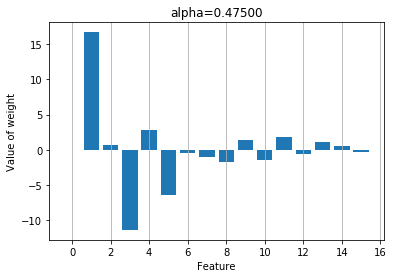

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.72472
Feature: 2, Score: 0.61813
Feature: 3, Score: -11.40704
Feature: 4, Score: 2.84079
Feature: 5, Score: -6.38709
Feature: 6, Score: -0.43850
Feature: 7, Score: -1.07616
Feature: 8, Score: -1.73547
Feature: 9, Score: 1.38650
Feature: 10, Score: -1.47648
Feature: 11, Score: 1.80386
Feature: 12, Score: -0.54801
Feature: 13, Score: 1.05947
Feature: 14, Score: 0.53867
Feature: 15, Score: -0.27875


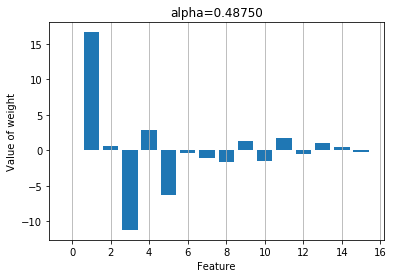

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.61260
Feature: 2, Score: 0.63579
Feature: 3, Score: -11.21605
Feature: 4, Score: 2.79206
Feature: 5, Score: -6.34997
Feature: 6, Score: -0.42546
Feature: 7, Score: -1.13318
Feature: 8, Score: -1.70202
Feature: 9, Score: 1.31087
Feature: 10, Score: -1.45513
Feature: 11, Score: 1.75432
Feature: 12, Score: -0.55195
Feature: 13, Score: 1.05819
Feature: 14, Score: 0.50722
Feature: 15, Score: -0.22248


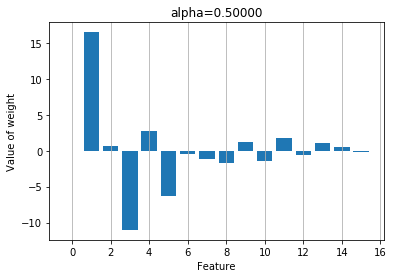

Number of features=15
Feature: 0, Score: 0.00000
Feature: 1, Score: 16.50329
Feature: 2, Score: 0.65236
Feature: 3, Score: -11.03173
Feature: 4, Score: 2.74563
Feature: 5, Score: -6.31296
Feature: 6, Score: -0.41275
Feature: 7, Score: -1.18696
Feature: 8, Score: -1.66983
Feature: 9, Score: 1.23860
Feature: 10, Score: -1.43463
Feature: 11, Score: 1.70649
Feature: 12, Score: -0.55580
Feature: 13, Score: 1.05619
Feature: 14, Score: 0.47682
Feature: 15, Score: -0.16965


In [23]:
## your code
for alpha in ALPHAS:    
    importance = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)['reg'].coef_
    val=np.count_nonzero(importance)
    plt.bar([i for i in range(len(importance))], importance)
    plt.title("alpha=%.5f" %(alpha))
    plt.xlabel("Feature")
    plt.ylabel("Value of weight")
    plt.grid(axis="x")
    plt.show()
    print("Number of features=%d" %val)
    # summarize feature importance
    for i,v in enumerate(importance):
  
      print('Feature: %0d, Score: %.5f' % (i,v))

#### Summary

Как мы видно из графиков, L1 зануляет веса фичей.
Главное отчличие в  производных функций, т.к градиентный спуск в основном движется в направлении производной. L1-регуляризация дополнительный член – модуль ,L2-регуляризации - квадратичнай функция.
При квадратичном члене чем ближе вы находитесь к нулю, тем меньшей становится ваша производная, соответсвенно приблежается к нулю. Поэтому при L2-регуляризации когда ваша величина веса уже мала, дальнейший градиентный спуск уже её сильно не изменит. В случае модуля производная является константой с абсолютной величиной. Поэтому при L1-регуляризации градиентный спуск будет стремиться к нулю с постоянной скоростью, а достигнув его, там и останется. Вследствие этого L2-регуляризация способствует малой величине весовых коэффициентов, а L1-регуляризация способствует их равенству нулю.

### Excercise 3 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Why is scaling important? What are the underlying reasons?

Масштабирование функций необходимо для того, чтобы все функции(фичи) имели одинаковую важность.
StandardScaler предполагает, что данные обычно распределяются внутри каждого элемента, и масштабируются таким образом, что распределение центрируется вокруг 0, со стандартным отклонением 1.
Центрирование и масштабирование происходит независимо от каждого элемента путем вычисления соответствующих статистических данных по выборкам в учебном наборе.

